# GLLVM Longitudinal

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from GLLVM_longitudinal import LongitudinalGLLVM


# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


A Longitudinal GLLVM is a model with 1 variable per period for T periods, n observations, and p responses, and k covariates. We also have a random effect for each observation x response.

In [2]:
n = 1000
p = 13
q = 1
k = 3
T = 9

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

In [3]:
response_types = {
    'binary': [0,1,2,3,4,5,6,7, 9, 10],
    'counts': [8, 11, 12]
}

They can be of many response types. Here for the sake of illutration we will consider 3 response types: gaussian, binary, and poisson.

We allow for transformation of the data, which we account for in the estimation. In particular, Poisson data may be numerically problematic because their conditional expectation is the exponential of the linear predictor. Small differences in the latter can result in dramatic differences in the gradient. For instance, we can transform poisson with the following function $x \rightarrow \log(x+1)$. This transforms is needed in 2 places: for encoding, and at the loss function for computing the gradient.

## Computing the scale parameter

The scale parameter is computed in a second step (on the fit residual). They are updated at every iteration. This is not yet implemented.


### Modules

We need LongitudinalGLLVM as the overarching module, Sample which samples the data and takes additional arguments (such as nuisance parameters), Decoder which contains all the parameters of interest, and Encoder which encodes the data using a Neural Network.

### Design of the Encoder
Since the estimation problem for Z is the same at each time step, we model the encoder using a RNN. At each time step, the same encoder is used to compute the Z. At the same time, the hidden state of the RNN is used to predict the U variable, which is constant over time for each observation.

### Accounting for missing values
Missing values are simply imputed every period by their (conditional) mean.

In [4]:
model_true = LongitudinalGLLVM(num_var=p, num_latent=q, num_covar=k, num_period=T, response_types=response_types).to(device)

In [5]:
data_sample = model_true.sample(x=None, n=n)

# adding missing data
probability_missing = 0.4
mask = torch.rand_like(data_sample['y']).to(device) < probability_missing
data_sample['y'][mask] = 0.5

In [6]:
model_true.decoder.wz.device
model_true.sample.phi.device

device(type='cuda', index=0)

In [7]:
model = LongitudinalGLLVM(num_var=p, num_latent=q, num_covar=k, num_period=T, response_types=response_types).to(device)

In [8]:
fit = model.fit(x=data_sample['x'], y=data_sample['y'], mask=mask, epochs=100, lr_model=0.1, lr_encoder=0.01)

var_u: Parameter containing:
tensor([0.9962], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.3813], device='cuda:0', requires_grad=True)

Epoch 1/100, loss_fit = 193083.59, encoder_loss = 1.41.
var_u: Parameter containing:
tensor([0.9944], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.3947], device='cuda:0', requires_grad=True)

Epoch 2/100, loss_fit = 192811.45, encoder_loss = 1.17.
var_u: Parameter containing:
tensor([1.0433], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.3979], device='cuda:0', requires_grad=True)

Epoch 3/100, loss_fit = 192851.38, encoder_loss = 1.03.
var_u: Parameter containing:
tensor([1.1040], device='cuda:0', requires_grad=True), phi: Parameter containing:
tensor([0.4094], device='cuda:0', requires_grad=True)

Epoch 4/100, loss_fit = 192285.88, encoder_loss = 1.01.
var_u: Parameter containing:
tensor([1.1505], device='cuda:0', requires_grad=True), phi: Parameter containing:
t

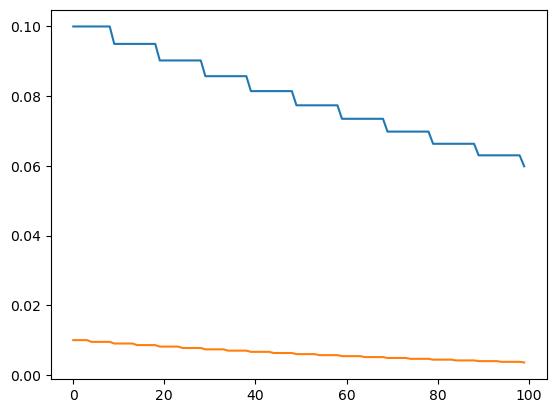

In [9]:
plt.plot(fit['learning_rates'])
plt.plot(fit['learning_rates_encoder'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


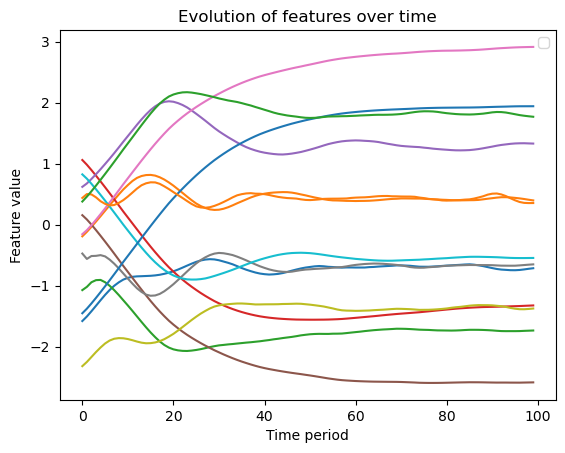

In [10]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in fit['loading_values']], axis=0)

# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i])

# Add legend and labels
ax.legend()
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


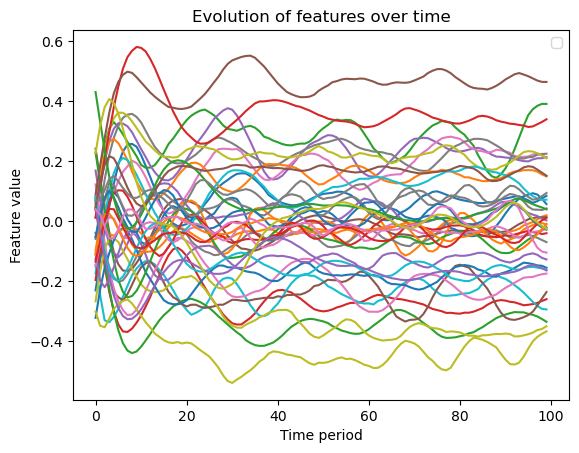

In [11]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in fit['coef_values']], axis=0)

# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i])

# Add legend and labels
ax.legend()
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


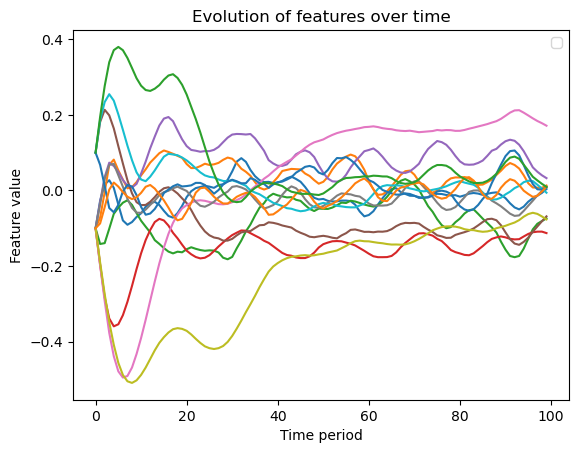

In [12]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in fit['intercept_values']], axis=0)

# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i])

# Add legend and labels
ax.legend()
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()


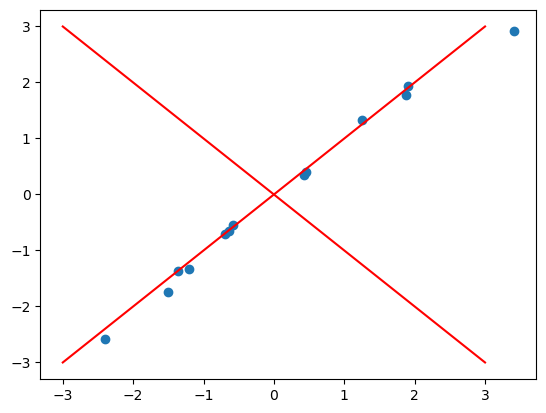

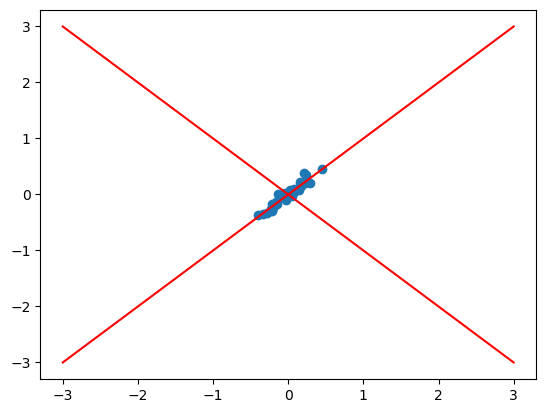

In [13]:
plt.scatter(model_true.decoder.wz.detach().cpu().numpy(), model.decoder.wz.detach().cpu().numpy())
plt.plot([-3,3], [-3,3], color="red")
plt.plot([-3,3], [3,-3], color="red")
plt.show()

plt.scatter(model_true.decoder.wx.detach().cpu().numpy(), model.decoder.wx.detach().cpu().numpy())
plt.plot([-3,3], [-3,3], color="red")
plt.plot([-3,3], [3,-3], color="red")
plt.show()

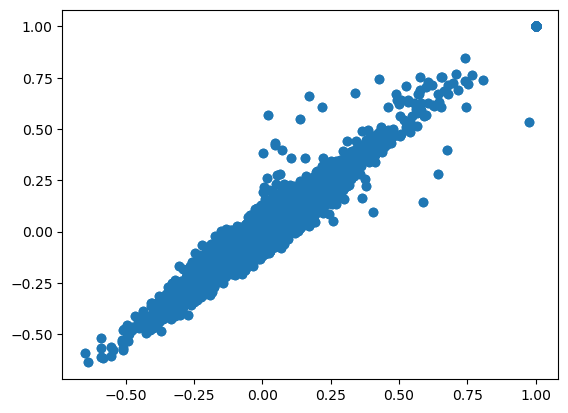

In [14]:
dat1 = torch.reshape(model_true.sample(x=data_sample['x'])['y'].detach().cpu(), (data_sample['y'].shape[0], -1))
cor1 = np.corrcoef(dat1, rowvar=False)
dat2 = torch.reshape(model.sample(x=data_sample['x'])['y'].detach().cpu(), (data_sample['y'].shape[0], -1))
cor2 = np.corrcoef(dat2, rowvar=False)

plt.scatter(cor1, cor2)
plt.show()

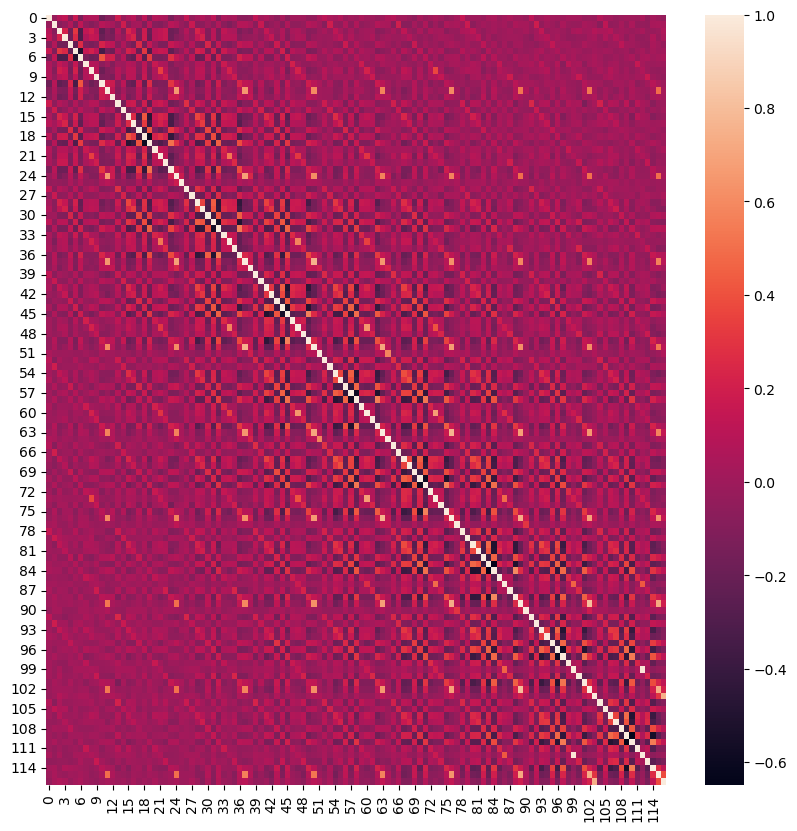

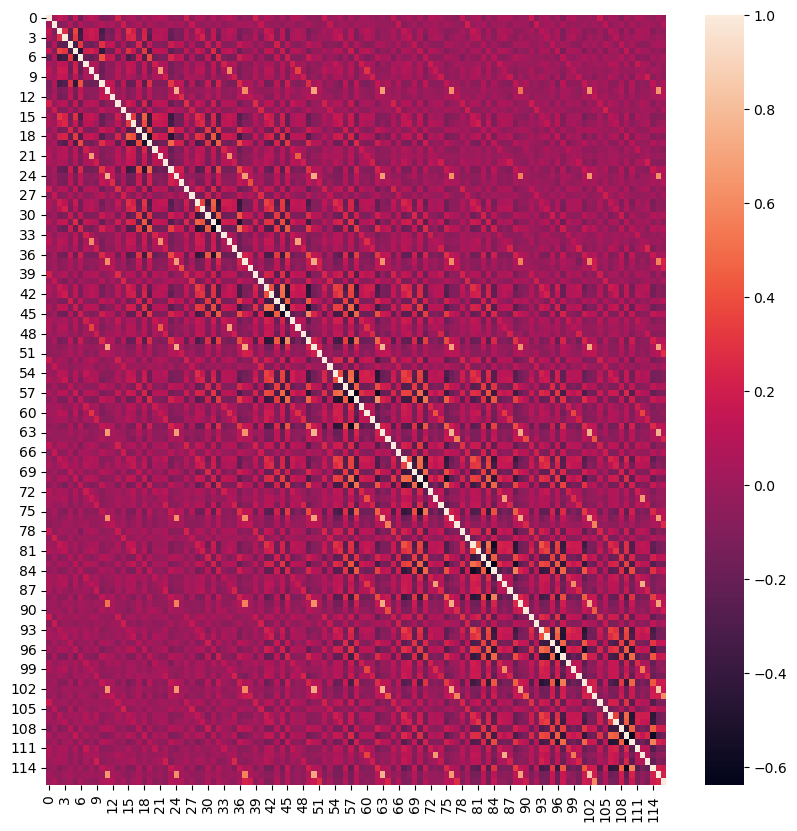

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(cor1, annot=False, fmt='g')
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(cor2, annot=False, fmt='g')
plt.show()